# <center>Курсовой проект</center>
## <center>Предсказание цен на недвижимость</center>

**План занятия**
* Загрузка данных
1. EDA
2. Обработка выбросов
3. Обработка пропусков
4. Построение новых признаков
5. Отбор признаков
6. Разбиение на train и test
7. Построение модели
8. Прогнозирование на тестовом датасете

**Подключение библиотек и скриптов**

In [737]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold

from datetime import datetime

import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [738]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

##Функции

In [739]:
def reduce_mem_usage(df):
    """ Функция для уменьшения использования памяти, путем изменения типов данных
        с большого на меньший"""
    start_mem = df.memory_usage().sum() / 1024**2
    print('Использовано памяти Датасетом {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Использовано памяти после оптимизации: {:.2f} MB'.format(end_mem))
    print('Уменьшилось на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [740]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """Функция для оценки работы модели - R2"""
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))

    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [741]:
TRAIN_DATASET_PATH = '../Course_project/train.csv'
TEST_DATASET_PATH = '../Course_project/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [742]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [743]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [744]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


### Приведение типов

In [745]:
print("Типы данных используемые в Датасете")
train_df.dtypes

Типы данных используемые в Датасете


Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [746]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Уменьшение объема памяти, который занимает датасет

In [747]:
train_df = reduce_mem_usage(train_df)

Использовано памяти Датасетом 1.53 MB
Использовано памяти после оптимизации: 0.82 MB
Уменьшилось на 46.0%


In [748]:
print("Типы данных в Датасете, после оптимизации:")
train_df.dtypes

Типы данных в Датасете, после оптимизации:


Id               category
DistrictId       category
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

## 1. EDA
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Целевая переменная**

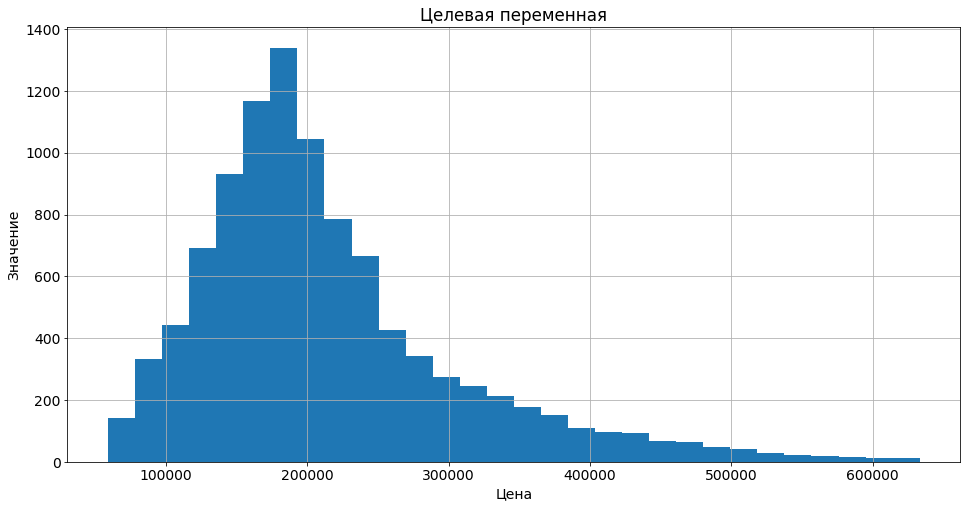

In [749]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.xlabel("Цена")
plt.ylabel("Значение")
plt.title('Целевая переменная')
plt.show()

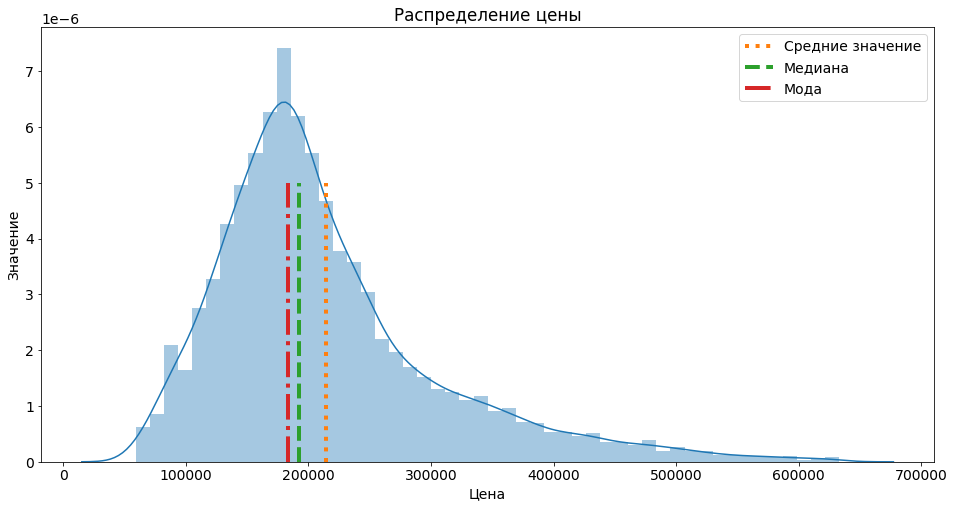

In [750]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.xlabel("Цена")
plt.ylabel("Значение")
plt.plot([target_mean] * 10, y, label='Средние значение', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='Медиана', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='Мода', linestyle='-.', linewidth=4)

plt.title('Распределение цены')
plt.legend()
plt.show()


In [751]:
print("Основные признаки")
train_df.describe()

Основные признаки


,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


**Номинативные переменные**

In [752]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
209      1
174      1
199      1
Name: DistrictId, Length: 205, dtype: int64

In [753]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [754]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [755]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов


**Признак Rooms**

Количество комнат:

In [756]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Исходя из данных видно, что количество комнат более 6, является выбросом, поэтому заменим эти данные медианной и
добавим признак, где укажем что была произвдена замена данных.

In [757]:
train_df['Rooms_outlier'] = 0

train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,0


In [758]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

Количество комнат, после обработки выбросов:

In [759]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**Признак Suqare**

In [760]:
train_df['Square'].min(),train_df['Square'].max()

(1.1368588, 641.0652)

Square - общая блощадь квартиры, судя по данным доступным в интернете минимальная площадь квартирын но нормам
САНПИН равна 14 кв. м. Заменим все значения меньше этой величины на указанную. С верхней границей ничего делать
не будем, в целом сверх дорогой дом может иметь площадь 600 кв. м

In [761]:
train_df.loc[(train_df['Square'] < 14),'Square'] = 14
print(f"Минимальная площадь: {train_df['Square'].min()} кв.м,"
      f"\nмаксимальная площадь {train_df['Square'].max()} кв.м")

Минимальная площадь: 14.0 кв.м,
максимальная площадь 641.065185546875 кв.м


**Признак KitchenSquare**

Площадь кухней

In [762]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

Как видно, что у площади кухни, очень большой разброс, приведем значения к адекватным данным,
путем замены выбросом - квантилем.

In [763]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))

train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

Площадь кухней после обработки

In [764]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**Признаки - HouseFloor, Floor**

Признак - этажности дома

In [765]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

Данные из Датасета, сделаны по городу Москве, там сам высокое здание Башня Восток, с высотой 95 этажей.
Поэтому все, что больше 95 этажей является выбросом и где этажность равняется 0 и заменим медианой.

Признак - на каком этаже находится квартира

In [766]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

Выбросов не обнаружено. Но не везде этаж квартиры соответсвует, этажности дома. Произвдем замену.

Сумма значений, где этаж квартиры, больше этажности дома:

In [767]:
print((train_df['Floor'] > train_df['HouseFloor']).sum())

1825


В датасете - 1825 значений, где этаж больше, чем этажности дома, скорее всего перепутаны значения этажа и этажности,
сначала сделаем признак проблемности с этажом или этажностью, а потом произвдем замену этажи и этажности дома.

In [768]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1
m = train_df['Floor'] > train_df['HouseFloor']
mp = {'Floor': 'HouseFloor', 'HouseFloor': 'Floor'}
train_df.update(train_df.loc[m].rename(mp, axis=1))



Сумма значений, где этаж квартиры, больше этажности дома, после обработки:

In [769]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

После перестановки значений, все выбросы ушли, что указывает, на ошибку заполнения данных.

**Признак LifeSquare**

Выбросы, где жилая площадь больше общей площади:

In [770]:
train_df.loc[train_df['LifeSquare'] > train_df['Square'] - train_df['KitchenSquare'] - 3]['LifeSquare'].count()

1234

LifeSquare - жилая площадь не должна быть больше чем общая площадь за вычетом площади кухни и 3х кв. м (на санузел
и прочие нежилые части помещения), если такая ситуация возникает заменяем значение жилой площади на значение разности
общей площади и кухни и 3 кв. м. Если жилая площадь в 2 и более раза меньше чем разность общей площади, площади кухни
и 3 кв. м - заменяем значение на значение разности общей площади и кухни и 3 кв. м.
Пропуски жилой площади обработаем отдельно

In [771]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square'] - train_df['KitchenSquare'] - 3),
             'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare'] - 3

train_df.loc[(train_df['LifeSquare'] < (train_df['Square'] - train_df['KitchenSquare'] - 3)/2),
             ['LifeSquare']] = train_df['Square'] - train_df['KitchenSquare'] - 3

Выбросы, после обработки, признака - общей площади:

In [772]:
train_df.loc[train_df['LifeSquare'] < (train_df['Square'] - train_df['KitchenSquare'] - 3)/2]['LifeSquare'].count()

0

**Признак HouseYear**

Список постройки дома, от большего к меньшему

In [773]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011.0
8828        4968.0
7721        2020.0
9122        2020.0
7955        2020.0
           ...    
7610        1916.0
6250        1914.0
2066        1912.0
2795        1912.0
6794        1910.0
Name: HouseYear, Length: 10000, dtype: float64

Как видно из списка, что первый дом построен в 1910 г., что нормально. А максимальный год уход за грань разумного,
обработаю данные выбросы.

In [774]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### 3. Обработка пропусков

Общее количество пропусков:

In [775]:
train_df.isna().sum()


Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

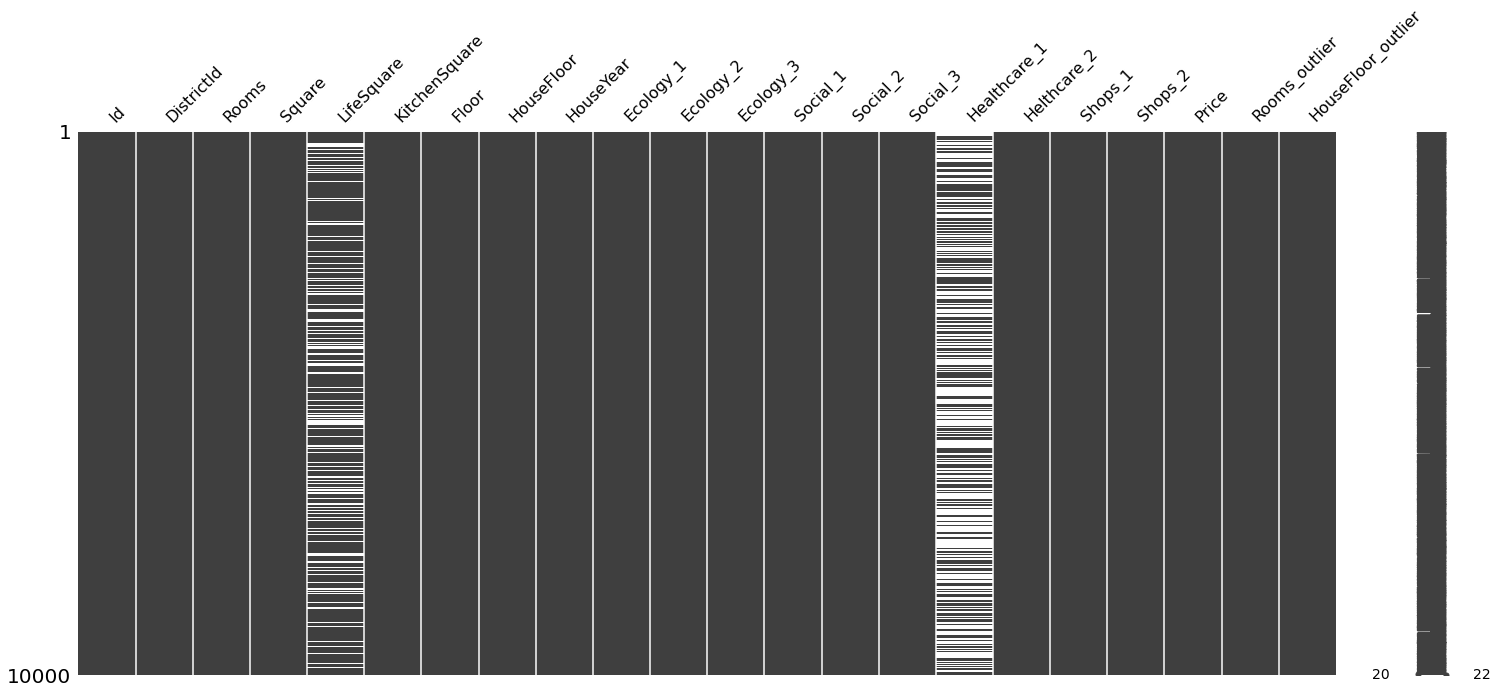

In [776]:
msno.matrix(train_df);


По сути имеем 2 признака с пропусками:

1. LifeSquare - Жилая площадь пропусков достаточно много, но можно постаратсья восстановить признак,
при этом он может существенно влиять на стоимость.
2. Healthcare_1 - показатель связанный с охраной здоровья, пропусков очень много почти 50% -
его просто выбросим.

LifeSquare - пропуски жилой площади будем заполнять следущими расчетными данными. Возьмем общую площадь и вычтем из неё
площадь кухни и минимальную площадь служебных помещений, а так же предусмотрим возможность проверки, общей площади и
площади кухни на пустые значения.

In [777]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())

train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

train_df.isna().sum()
train_df.drop('Healthcare_1', axis=1, inplace=True)

train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
LifeSquare_nan        0
dtype: int64

In [778]:

class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None

    def fit(self, X):
        """Сохранение статистик"""
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)

    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1

        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']

        # Square
        X.loc[X['Square'] < 14,'Square'] = 14

        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)

        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3

        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1

        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']

        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))

        # LifeSquare

        X.loc[(X['LifeSquare'] > X['Square'] - X['KitchenSquare'] - 3),
              'LifeSquare'] = X['Square'] - X['KitchenSquare'] - 3

        X.loc[(X['LifeSquare'] < (X['Square'] - X['KitchenSquare'] - 3)/2),
             ['LifeSquare']] = X['Square'] - X['KitchenSquare'] - 3

        # HouseYear
        current_year = datetime.now().year

        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1

        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year

        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)

        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())

        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3


        X.fillna(self.medians, inplace=True)

        return X

### 4. Построение новых признаков

**Dummies кодирование**

Всего имеем 3 категориальных признака которые по сути можно закодировать бинарно:

    1. Ecology_2
    2. Ecology_3
    3. Shops_2

In [779]:
binary_to_numbers = {'A': 0, 'B': 1}
train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**
Переводим DistrictId в вещественный признак.

In [780]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.drop("DistrictId", axis=1, inplace=True)
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**Средняя стоимость в зависимости от района и комнат**

Создаем новый признак, в зависимости от района и количества комнат в доме от цены.
А так же делаем проверку на пустые значения и если они есть заполняем их медианной.

In [781]:
med_price_by_district = train_df.groupby(['DistrictSize', 'Rooms'], as_index=False)\
                                   .agg({'Price':'median'})\
                                   .rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district_median = med_price_by_district['MedPriceByDistrict'].median()
train_df = train_df.merge(med_price_by_district, on=['DistrictSize', 'Rooms'], how='left')
train_df.fillna({'MedPriceByDistrict':med_price_by_district_median}, inplace=True)
train_df.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,3.0,115.027313,102.027313,10.0,4.0,10.0,2014.0,0.075424,1,...,0.0,0.0,1,305018.875000,0.0,0.0,1,851,1,213530.781250
1,3013,1.0,39.832523,23.169222,8.0,7.0,8.0,1966.0,0.118537,1,...,1.0,0.0,1,177734.546875,0.0,0.0,0,78,0,165759.000000
2,8215,3.0,78.342216,47.671970,10.0,2.0,17.0,1988.0,0.025609,1,...,3.0,1.0,1,282078.718750,0.0,0.0,0,652,1,244005.281250
3,2352,1.0,40.409908,34.409908,3.0,10.0,22.0,1977.0,0.007122,1,...,0.0,1.0,1,168106.000000,0.0,0.0,1,652,1,146735.671875
4,13866,2.0,64.285065,38.562515,9.0,16.0,16.0,1972.0,0.282798,1,...,0.0,6.0,1,343995.093750,0.0,0.0,0,89,0,192188.937500


**Средняя стоимость в зависимости от этажности и возраста дома**

In [782]:
def floor_to_cat(x):
    """Добавляет категорию этажности с разбиением на 5 групп"""
    bins = [0, 3, 5, 9, 15, x['Floor'].max()]
    x['floor_cat'] = pd.cut(x['Floor'], bins=bins, labels=False)

    x['floor_cat'].fillna(-1, inplace=True)
    return x

def year_to_cat(x):
    """Добавляет категорию возраста дома разбив на 5 групп"""
    bins = [0, 1941, 1945, 1980, 2000, 2010, x['HouseYear'].max()]
    x['year_cat'] = pd.cut(x['HouseYear'], bins=bins, labels=False)

    x['year_cat'].fillna(-1, inplace=True)
    return x

Добавляем два столбца "year_cat" и "floor_cat", первый - разбиваем этажность дома на 5 категорий, а второй - разбивает
год строительства дома на 5 групп.

In [783]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,3.0,115.027313,102.027313,10.0,4.0,10.0,2014.0,0.075424,1,...,1,305018.875000,0.0,0.0,1,851,1,213530.781250,5,1.0
1,3013,1.0,39.832523,23.169222,8.0,7.0,8.0,1966.0,0.118537,1,...,1,177734.546875,0.0,0.0,0,78,0,165759.000000,2,2.0
2,8215,3.0,78.342216,47.671970,10.0,2.0,17.0,1988.0,0.025609,1,...,1,282078.718750,0.0,0.0,0,652,1,244005.281250,3,0.0
3,2352,1.0,40.409908,34.409908,3.0,10.0,22.0,1977.0,0.007122,1,...,1,168106.000000,0.0,0.0,1,652,1,146735.671875,2,3.0
4,13866,2.0,64.285065,38.562515,9.0,16.0,16.0,1972.0,0.282798,1,...,1,343995.093750,0.0,0.0,0,89,0,192188.937500,2,4.0


Добавляем столбец - MedPriceByFloorYear. Где указана средняя стоимость в зависимости от этажности и возраста дома.

In [784]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year_median = med_price_by_floor_year['MedPriceByFloorYear'].median()
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.fillna({'MedPriceByFloorYear':med_price_by_floor_year_median}, inplace=True)
train_df.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,3.0,115.027313,102.027313,10.0,4.0,10.0,2014.0,0.075424,1,...,305018.875000,0.0,0.0,1,851,1,213530.781250,5,1.0,161825.406250
1,3013,1.0,39.832523,23.169222,8.0,7.0,8.0,1966.0,0.118537,1,...,177734.546875,0.0,0.0,0,78,0,165759.000000,2,2.0,193455.828125
2,8215,3.0,78.342216,47.671970,10.0,2.0,17.0,1988.0,0.025609,1,...,282078.718750,0.0,0.0,0,652,1,244005.281250,3,0.0,205210.062500
3,2352,1.0,40.409908,34.409908,3.0,10.0,22.0,1977.0,0.007122,1,...,168106.000000,0.0,0.0,1,652,1,146735.671875,2,3.0,184232.546875
4,13866,2.0,64.285065,38.562515,9.0,16.0,16.0,1972.0,0.282798,1,...,343995.093750,0.0,0.0,0,89,0,192188.937500,2,4.0,175503.765625


In [785]:

class FeatureGenetator():
    """Генерация новых фич"""

    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.med_price_by_district_median = None

    def fit(self, X, y=None):

        X = X.copy()

        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}

        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})


        # Target encoding
        ## District, Rooms
        df = X.copy()

        if y is not None:
            df['Price'] = y.values

            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})

            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()

        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()



    def transform(self, X):

        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)

        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')

        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1

        X['DistrictSize'].fillna(5, inplace=True)

        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)

        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat

        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)

        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)

        return X

    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X

    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X


### 5. Отбор признаков

Производим формирования переменных, снужными для нас признаками.
Не включаем не нужные столбцы Id, DistrictId, year_cat, floor_cat.
Разбиваем на признки, новые признаки и на главный объект.

In [786]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

### 6. Разбиение на train и test

Считываем по новой файлы и производим разбивка Датасета на тренировачный и тестовый Датасеты.

In [787]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [788]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

Проводим обучение на сформированых данных.

Проверяем количество данных на выходе после обучения:

In [789]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

Проверяем количество данных на выходе после обучения и добавяления новых фич:

In [790]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [791]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

Проверяем количество пропусков в Датасетах, после обучения:

In [792]:
X_train.head()
X_valid.head()
y_train.head()
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели

**Обучение**

In [793]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_valid = pd.DataFrame(scaler.transform(X_valid))
test_df = pd.DataFrame(scaler.transform(test_df))

In [794]:
model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=20,
                                     min_samples_leaf=24,
                                     random_state=21,
                                     n_estimators=265,
                                     max_features='sqrt',
                                     loss='huber',
                                     learning_rate=0.025)
model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=20, max_features='sqrt',
                          min_samples_leaf=24, n_estimators=265,
                          random_state=21)

**Оценка модели**

Train R2:	0.89
Test R2:	0.726


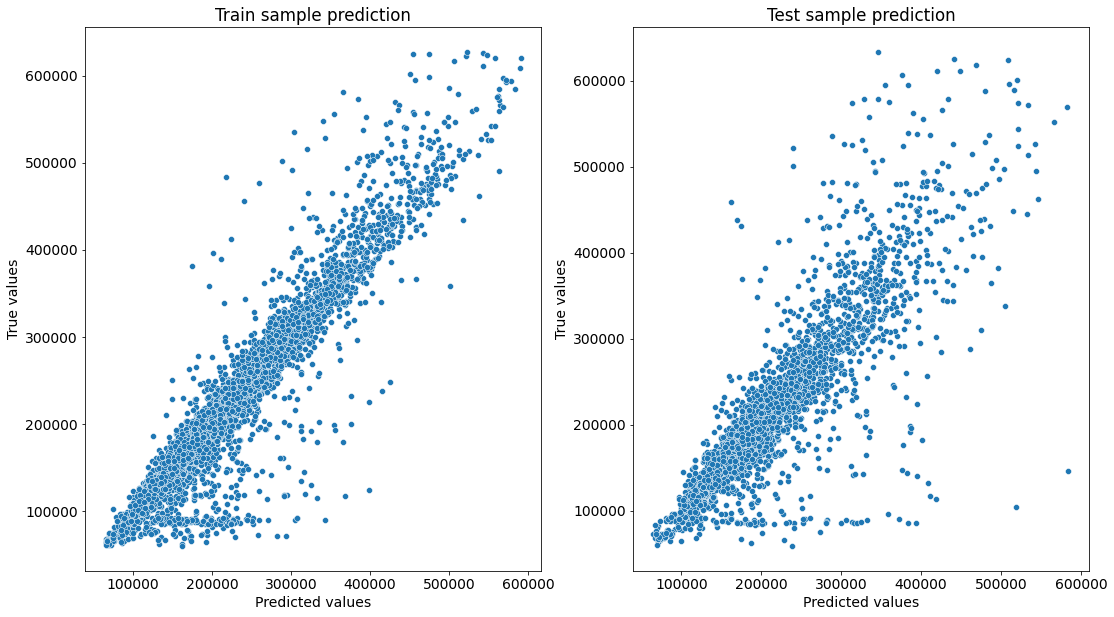

In [795]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [796]:
cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.78970351, 0.74928909, 0.77437192])

**Среднее значение кросс-валидации:**

In [797]:
cv_score.mean()

0.7711215061132052

### 8. Прогнозирование на тестовом датасете

In [798]:
submit = pd.read_csv('../Course_project/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [799]:
predictions = model.predict(test_df)
predictions

array([166831.64795055, 121960.52234758, 140348.19420416, ...,
       146455.66744563, 188143.22638876, 219780.80009923])

In [800]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,166831.647951
1,5925,121960.522348
2,960,140348.194204
3,3848,125919.314247
4,746,192258.193371


In [801]:
submit.shape


(5000, 2)

In [802]:
submit.to_csv('../Course_project/submit.csv', index=False)